In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv("Downloads/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

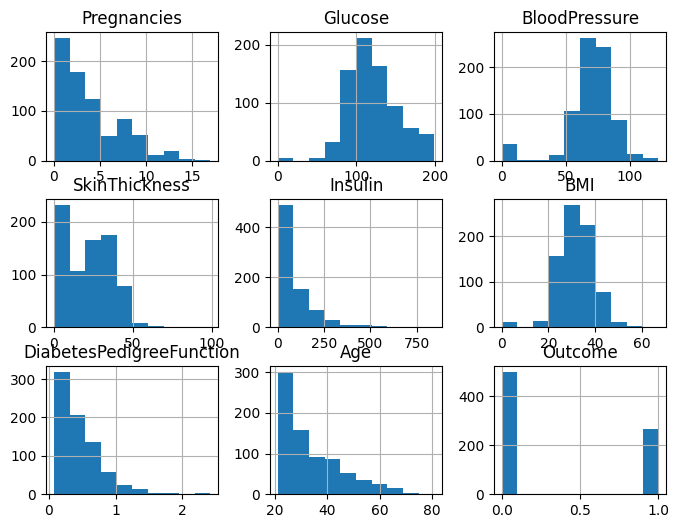

In [4]:
data.hist(figsize=(8,6))

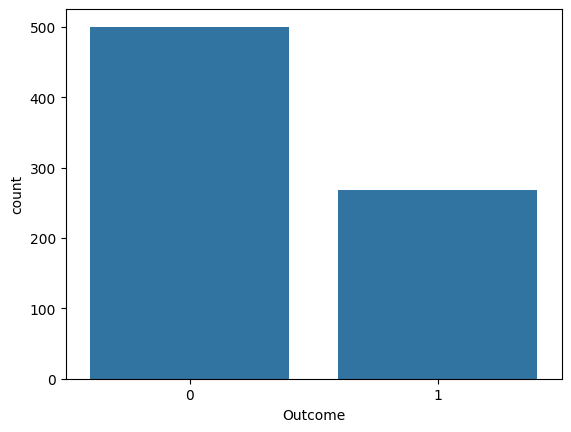

In [5]:
import seaborn as sns
sns.countplot(x="Outcome",data=data)
plt.show()

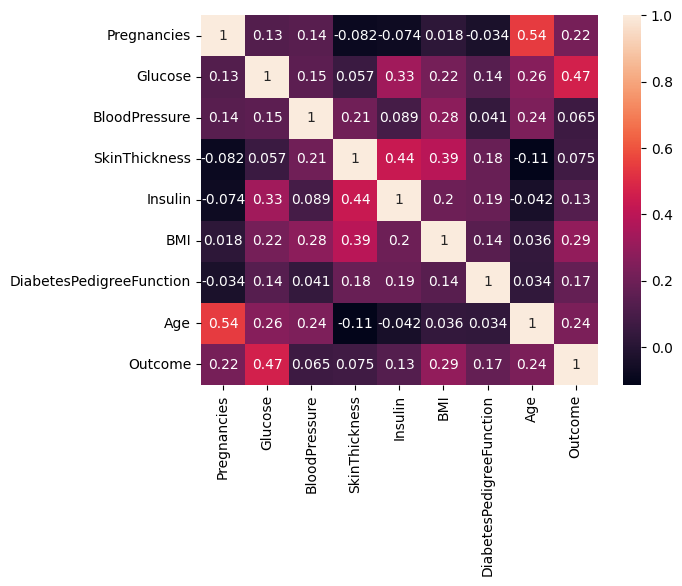

In [6]:
sns.heatmap(data.corr(), annot=True)
plt.show()

In [7]:
data[(data['Glucose'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [8]:
cleaned_data = data[(data['Glucose'] != 0)]
cleaned_data.shape

(763, 9)

In [9]:
feature_engg_data=cleaned_data.copy()
outlier_data=cleaned_data.copy()
factor=3

columns_to_include=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
for column in columns_to_include:
    upper_lim=feature_engg_data[column].mean()+feature_engg_data[column].std()*factor
    lower_lim=feature_engg_data[column].mean()-feature_engg_data[column].std()*factor
    feature_engg_data=feature_engg_data[(feature_engg_data[column]<upper_lim)&(feature_engg_data[column] > lower_lim)]
outlier_data=pd.concat([outlier_data,feature_engg_data]).drop_duplicates(keep=False)

print(feature_engg_data.shape)
print(outlier_data.shape)

(688, 9)
(75, 9)


In [11]:
from sklearn.preprocessing import MinMaxScaler
def normalize(df):
    scaler=MinMaxScaler()
    norm_vals=scaler.fit_transform(df)
    return pd.DataFrame(norm_vals, columns=df.columns)

feature_data=feature_engg_data.drop('Outcome', axis=1)
target_data=feature_engg_data['Outcome']
norm_feature_data=normalize(feature_data)

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(norm_feature_data, target_data, test_size=0.2, random_state=5)


In [13]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=200, random_state=5)
rfc.fit(X_train,y_train)
importances=pd.Series(rfc.feature_importances_, index=feature_data.columns)
important_features = importances.sort_values(ascending=False)
important_features

Glucose                     0.264759
Age                         0.142215
BMI                         0.141224
DiabetesPedigreeFunction    0.138696
Pregnancies                 0.085626
BloodPressure               0.080587
Insulin                     0.077177
SkinThickness               0.069716
dtype: float64

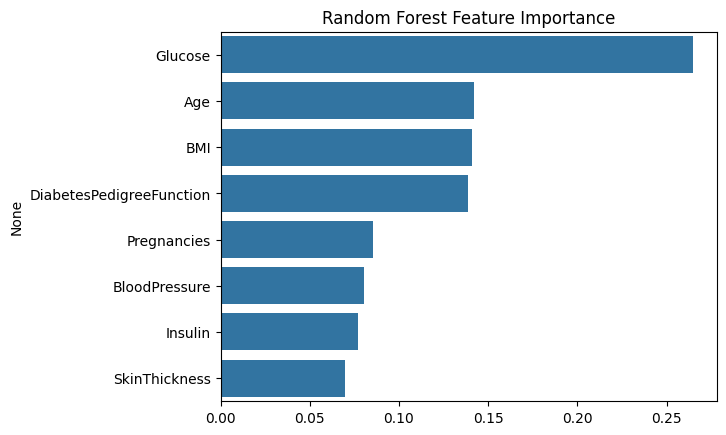

In [16]:
sns.barplot(x=important_features.values, y=important_features.index)
plt.title('Random Forest Feature Importance')
plt.show()

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
def build_model(input_dim):
    inp=Input(shape=(input_dim,))
    x=Dense(40,activation='relu')(inp)
    x=Dense(40,activation='relu')(x)
    out=Dense(2,activation='softmax')(x)
    model=Model(inp,out)
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
from tensorflow.keras.utils import to_categorical
nn_model=build_model(X_train.shape[1])
history=nn_model.fit(X_train, to_categorical(y_train), epochs=10, batch_size=32, verbose=0)

In [26]:
sample_idx=5
query=X_test.iloc[sample_idx].values.reshape(1,-1)
true_label=y_test.iloc[sample_idx]
predicted_label=np.argmax(nn_model.predict(query))

print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")

1/1 [==============================] - 0s 94ms/step
True Label: 1
Predicted Label: 1


1/1 [==============================] - 0s 33ms/step


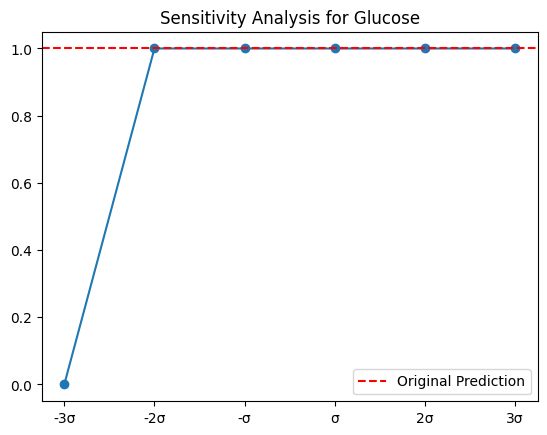

1/1 [==============================] - 0s 35ms/step


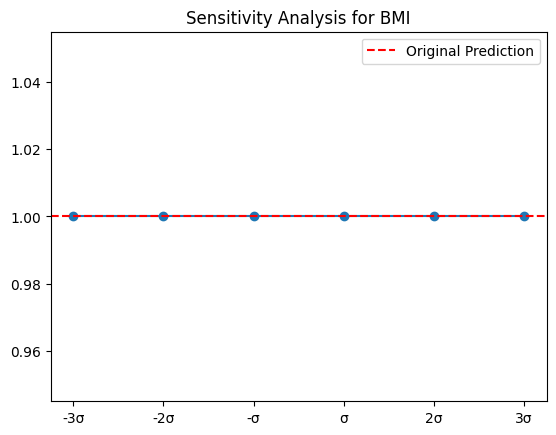

1/1 [==============================] - 0s 35ms/step


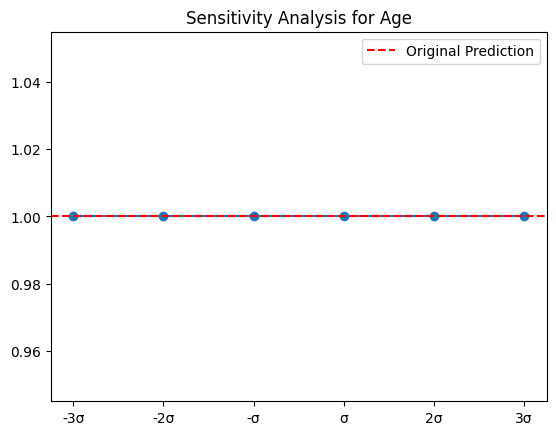

1/1 [==============================] - 0s 35ms/step


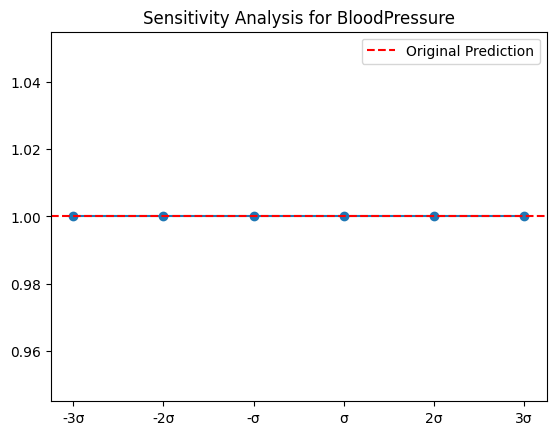

In [27]:
def sensitivity_plot(feature,sigma):
    variations=[-3,-2,-1,1,2,3]
    results=[]
    original=query.copy()
    for v in variations:
        temp=original.copy()
        temp[0, list(feature_data.columns).index(feature)] += v * sigma
        temp = np.clip(temp, 0, 1)
        pred = np.argmax(nn_model.predict(temp))
        results.append(pred)
    plt.plot(['-3σ', '-2σ', '-σ', 'σ', '2σ', '3σ'], results, marker='o')
    plt.axhline(y=predicted_label, color='r', linestyle='--', label='Original Prediction')
    plt.title(f'Sensitivity Analysis for {feature}')
    plt.legend()
    plt.show()

# Calculate standard deviations
sigmas = X_train.std()

# Plot for selected features
for feature in ['Glucose', 'BMI', 'Age', 'BloodPressure']:
    sensitivity_plot(feature, sigmas[feature])